---

## Khmer Sentiment Analysis with fastText
---

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
from datetime import datetime
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

### Load Train/Validation Data

In [ ]:
data = pd.read_excel("/content/drive/sentiment_analysis_data_km.xlsx", encoding="UTF-8")

In [4]:
data['text_prep'] = data['text_prep'].apply(lambda x: ' '.join(re.sub(r'[០១២៣៤៥៦៧៨៩។៕៖ៗ៘៙៚]+', ' ', x).strip().split()))
data.drop_duplicates(subset=['text_prep'], inplace=True)
data.head()

,source,texts,texts_km,text_prep,sentiment
0,Yelp,Wow... Loved this place.,អីយ៉ា ... ស្រឡាញ់កន្លែងនេះ។,អីយ៉ា ស្រឡាញ់ កន្លែង នេះ,1
1,Yelp,Crust is not good.,សំបកគឺជាការមិនល្អ។,សំបក គឺ ជា ការ មិន ល្អ,0
2,Yelp,Not tasty and the texture was just nasty.,មិនហ៊ាននិងវាយនភាពនេះគឺអាក្រក់គ្រាន់តែជា។,មិន ហ៊ាន និង វាយន ភាព នេះ គឺ អាក្រក់ គ្រាន់ តែ ជា,0
3,Yelp,Stopped by during the late May bank holiday of...,បញ្ឈប់ដោយក្នុងអំឡុងពេលថ្ងៃឈប់សម្រាកចុងខែឧសភាបិ...,បញ្ឈប់ ដោយ ក្នុង អំឡុង ពេល ថ្ងៃ ឈប់ សម្រាក ចុង...,1
4,Yelp,The selection on the menu was great and so wer...,ការជ្រើសនៅលើម៉ឺនុយនេះគឺអស្ចារ្យណាស់ហើយត្រូវបាន...,ការ ជ្រើស នៅ លើ ម៉ឺនុយ នេះ គឺ អស្ចារ្យ ណាស់ ហើ...,1


In [5]:
data = data.reset_index()

In [6]:
data.shape

(10710, 6)

In [7]:
data['sentiment'].value_counts()

1    5367
0    5343
Name: sentiment, dtype: int64

### Load Test Data

In [ ]:
# Load Test Data
data_test = pd.read_excel("/content/sentiment_analysis_test_data.xlsx")

In [ ]:
data_test['X_test'] = data_test['X_test'].apply(lambda x: ' '.join(re.sub(r'[០១២៣៤៥៦៧៨៩។៕៖ៗ៘៙៚]+', ' ', x).strip().split()))

In [ ]:
data_test.head()

,texts,X_test,y_test
0,ខ្ញុំត្រូវចាកចេញពីការងារ នឹងមិនអាចទៅរួចទេ។ ដូច...,ខ្ញុំ ត្រូវ ចាក ចេញ ពី ការងារ នឹង មិន អាច ទៅ រ...,0
1,សួស្តី។ យើងកំពុងហោះហើរ SWA ថ្ងៃនេះ។ កូនប្រុសរប...,សួស្តី យើង កំពុង ហោះ ហើរ ថ្ងៃ នេះ កូន ប្រុស រប...,0
2,សម្លៀកបំពាក់នេះមើលទៅហើយមានអារម្មណ៍ថាថោក។ សម្ភា...,សម្លៀកបំពាក់ នេះ មើល ទៅ ហើយ មាន អារម្មណ៍ ថា ថោ...,0
3,ធំពេកហើយវាមិនមានសុវត្ថិភាពគ្រប់គ្រាន់ពាក់សម្រា...,ធំ ពេក ហើយ វា មិន មាន សុវត្ថិ ភាព គ្រប់ គ្រាន់...,0
4,តើអ្នកដឹងទេនៅពេលផ្លូវថ្មីពី HOU ទៅ Aruba &amp ...,តើ អ្នក ដឹង ទេ នៅ ពេល ផ្លូវ ថ្មី ពី ទៅ នឹង អាច...,0


In [17]:
data_test.y_test.value_counts()

0    209
1    191
Name: y_test, dtype: int64

In [21]:
data_test['texts_tokenized'] = data_test.X_test.apply(lambda x: x.split())

In [22]:
data_test.head(3)

,texts,X_test,y_test,texts_tokenized
0,ខ្ញុំត្រូវចាកចេញពីការងារ នឹងមិនអាចទៅរួចទេ។ ដូច...,ខ្ញុំ ត្រូវ ចាក ចេញ ពី ការងារ នឹង មិន អាច ទៅ រ...,0,"[ខ្ញុំ, ត្រូវ, ចាក, ចេញ, ពី, ការងារ, នឹង, មិន,..."
1,សួស្តី។ យើងកំពុងហោះហើរ SWA ថ្ងៃនេះ។ កូនប្រុសរប...,សួស្តី យើង កំពុង ហោះ ហើរ ថ្ងៃ នេះ កូន ប្រុស រប...,0,"[សួស្តី, យើង, កំពុង, ហោះ, ហើរ, ថ្ងៃ, នេះ, កូន,..."
2,សម្លៀកបំពាក់នេះមើលទៅហើយមានអារម្មណ៍ថាថោក។ សម្ភា...,សម្លៀកបំពាក់ នេះ មើល ទៅ ហើយ មាន អារម្មណ៍ ថា ថោ...,0,"[សម្លៀកបំពាក់, នេះ, មើល, ទៅ, ហើយ, មាន, អារម្មណ..."


### Data Partitioning

In [ ]:
X = data['text_prep']
y = data['sentiment']

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1234, shuffle=True, stratify=y)

X_test, y_test = data_test.texts_tokenized, data_test.y_test

print("""
Training shape:   {}
Validation shape: {}
Testing shape:    {}""".format(X_train.shape[0], X_val.shape[0], X_test.shape[0]))


Training shape:   8568
Validation shape: 2142
Testing shape:    400


### Load fastText pre-trained model

In [27]:
from gensim.models import KeyedVectors

path = "/content/drive/cc.km.300.vec"
fastText_model = KeyedVectors.load_word2vec_format(path, binary=False)

In [28]:
len(fastText_model.vocab)

242732

In [29]:
fastText_model.vector_size

300

### Feature Extraction

In [30]:
def embedding_vectorizer(fastText_model, docs):
    mean_vecs = []
    for instance in docs:
        vecs = []
        for word in instance:
            if word in fastText_model.vocab:
                vecs.append(fastText_model[word])
            else:
                vecs.append(np.zeros(fastText_model.vector_size))
                
        mean_vecs.append(np.mean(vecs, axis=0))
        
    return mean_vecs

In [31]:
%%time
x_train_vectorized = pd.DataFrame(embedding_vectorizer(fastText_model, X_train)).add_prefix('col_')

x_val_vectorized = pd.DataFrame(embedding_vectorizer(fastText_model, X_val)).add_prefix('col_')
x_test_vectorized = pd.DataFrame(embedding_vectorizer(fastText_model, X_test)).add_prefix('col_')

CPU times: user 2.68 s, sys: 119 ms, total: 2.8 s
Wall time: 2.8 s


### Model Architecture

In [32]:
import tensorflow as tf
import random as rn

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import History
from keras.optimizers import Adam, SGD

Using TensorFlow backend.


In [33]:
from keras.utils import to_categorical

y_train_k = to_categorical(y_train, num_classes=2)
y_val_k = to_categorical(y_val, num_classes=2)
y_test_k = to_categorical(y_test, num_classes=2)

In [115]:
np.random.seed(2)
rn.seed(3)
history = History()

model = Sequential()
model.add(Dense(1024, input_dim=300, activation="tanh"))
model.add(Dropout(0.1))
model.add(Dense(512, activation="tanh"))
model.add(Dropout(0.1))
model.add(Dense(256, activation="tanh"))
model.add(Dropout(0.1))
model.add(Dense(128, activation="tanh"))
# model.add(Dropout(0.1))
model.add(Dense(2, activation="softmax"))

model.compile(optimizer=Adam(0.001), loss="binary_crossentropy", metrics=['accuracy'])

model.fit(np.array(x_train_vectorized), np.array(y_train_k), 
          validation_data=(np.array(x_val_vectorized), np.array(y_val_k)), 
          epochs=44, 
          batch_size=3000, 
          shuffle=True, 
          callbacks=[history], 
          verbose=True)

Train on 8568 samples, validate on 2142 samples
Epoch 1/44
8568/8568 [==============================] - 1s 97us/step - loss: 0.7107 - accuracy: 0.4959 - val_loss: 0.7011 - val_accuracy: 0.5033
Epoch 2/44
8568/8568 [==============================] - 0s 11us/step - loss: 0.6836 - accuracy: 0.5493 - val_loss: 0.6843 - val_accuracy: 0.5065
Epoch 3/44
8568/8568 [==============================] - 0s 10us/step - loss: 0.6782 - accuracy: 0.5321 - val_loss: 0.6651 - val_accuracy: 0.6648
Epoch 4/44
8568/8568 [==============================] - 0s 10us/step - loss: 0.6578 - accuracy: 0.6333 - val_loss: 0.6469 - val_accuracy: 0.6368
Epoch 5/44
8568/8568 [==============================] - 0s 10us/step - loss: 0.6331 - accuracy: 0.6665 - val_loss: 0.6194 - val_accuracy: 0.6685
Epoch 6/44
8568/8568 [==============================] - 0s 10us/step - loss: 0.6071 - accuracy: 0.6806 - val_loss: 0.6056 - val_accuracy: 0.6751
Epoch 7/44
8568/8568 [==============================] - 0s 10us/step - loss: 0.586

In [117]:
## for learning curve
his_train_loss = history.history['loss']
his_val_loss = history.history['val_loss']

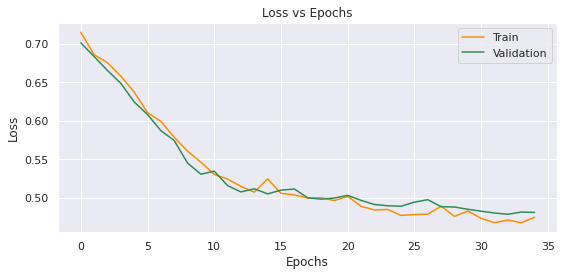

In [104]:
## Plot learning curve
import matplotlib.pyplot as plt
sns.set()
fig, ax = plt.subplots(figsize=(8,4))
plt.plot(his_train_loss[0:35],'darkorange')
plt.plot(his_val_loss[0:35], 'seagreen')

plt.title("Loss vs Epochs", fontdict={'fontsize': 12})
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
# plt.savefig("sentiment_loss_vs_epochs_fastText.jpg", dpi=300, bbox_inches='tight')
plt.show()

In [118]:
loss, test_accuracy = model.evaluate(np.array(x_test_vectorized), np.array(y_test_k), verbose=0)

In [121]:
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

print("Training Accuracy: %0.3f" %train_accuracy)
print("Validation Accuracy: %0.3f" %val_accuracy)
print("Test Accuracy: %0.3f" %test_accuracy)

accuracy_table = pd.DataFrame([round(train_accuracy, 3), round(val_accuracy, 3), round(test_accuracy, 3)], 
             index=['Training', 'Validation', 'Test'], 
             columns=['Accuracy'])
accuracy_table

Training Accuracy: 0.783
Validation Accuracy: 0.771
Test Accuracy: 0.767


,Accuracy
Training,0.783
Validation,0.771
Test,0.767


### Prediction

In [122]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [123]:
y_pred = model.predict(np.array(x_test_vectorized))
ac = accuracy_score(y_test_k.argmax(axis=1), y_pred.argmax(axis=1))
print("Test Accuracy:", round(ac, 2))

Test Accuracy: 0.77


In [125]:
## generate confusion matrix
print("Confusion Matrix: ")
cm = confusion_matrix(y_test_k.argmax(axis=1), y_pred.argmax(axis=1))
p = pd.DataFrame(cm, 
                 index=[['Actual']*2, ['Negative', 'Positive']], 
                 columns=[['Predicted']*2,['Negative', 'Positive']])

p.style.set_properties(**{'background-color': 'lightgrey', 
                          'color': 'black'})

Confusion Matrix: 


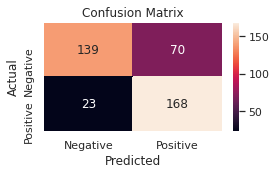

In [127]:
## Confusion Matrix in Heatmap
import matplotlib.pyplot as plt
import seaborn as sns
p = pd.DataFrame(cm, 
                 index = ['Negative', 'Positive'],
                 columns = ['Negative', 'Positive'])

plt.figure(figsize=(4, 2))
sns.set()
f = sns.heatmap(p, annot=True, fmt="d")
plt.title("Confusion Matrix", fontdict={'fontsize': 12})
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# f.get_figure().savefig("sentiment_confusion_matrix_fastText.jpg", dpi=300, bbox_inches='tight')

In [128]:
## Classification Report
target_names = ['Negative', 'Positive']
print(classification_report(y_test_k.argmax(axis=1), y_pred.argmax(axis=1), target_names = target_names))

              precision    recall  f1-score   support

    Negative       0.86      0.67      0.75       209
    Positive       0.71      0.88      0.78       191

    accuracy                           0.77       400
   macro avg       0.78      0.77      0.77       400
weighted avg       0.79      0.77      0.77       400

